In [1]:
import numpy as np
from array import *
import copy
import random
import pandas as pd
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from skimage import io
tf.__version__

'2.3.1'

In [2]:
dataset = pd.read_csv('skin_cancer_data1.csv', low_memory = False)
dataset_nv = pd.read_csv('skin_cancer_data2.csv', low_memory=False)

In [3]:
dataset = dataset.drop(labels='Unnamed: 0', axis=1)
dataset_nv = dataset_nv.drop(labels='Unnamed: 0', axis=1)

In [4]:
data = dataset.sample(frac = 1)

In [5]:
data['image'] = data['image'].apply(lambda x:(np.fromstring(x, dtype = int, sep = ' ')).reshape(96, 96, 3))
dataset_nv['image'] = dataset_nv['image'].apply(lambda x:(np.fromstring(x, dtype = int, sep = ' ')).reshape(96, 96, 3))

In [6]:
data_clockwise_90 = copy.copy(data)
data_clockwise_90['image'] = data_clockwise_90['image'].apply(lambda x: (cv2.rotate(x, cv2.cv2.ROTATE_90_CLOCKWISE)))

data_round_180 = copy.copy(data)
data_round_180['image'] = data_round_180['image'].apply(lambda x: (cv2.rotate(x, cv2.cv2.ROTATE_180)))

data_flip_ud = copy.copy(data)
data_flip_ud['image'] = data_flip_ud['image'].apply(lambda x: (cv2.flip(x, 0)))

data_flip_lr = copy.copy(data)
data_flip_lr['image'] = data_flip_lr['image'].apply(lambda x: (cv2.flip(x, 1)))

data_counterclockwise_90 = copy.copy(data)
data_counterclockwise_90['image'] = data_counterclockwise_90['image'].apply(lambda x: (
    cv2.rotate(x, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)))

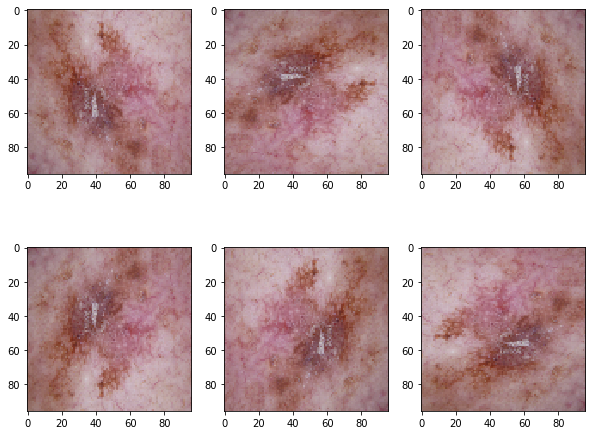

In [7]:
w_grid = 2
l_grid = 3
fig, axes = plt.subplots(w_grid, l_grid, figsize = (10, 8))
axes = axes.ravel()
j = np.random.randint(0, len(data))
axes[0].imshow(data['image'][j])
axes[1].imshow(data_clockwise_90['image'][j])
axes[2].imshow(data_round_180['image'][j])
axes[3].imshow(data_flip_ud['image'][j])
axes[4].imshow(data_flip_lr['image'][j])
axes[5].imshow(data_counterclockwise_90['image'][j])

In [8]:
data_array = data.iloc[:, :].values
data_clockwise_90_array = data_clockwise_90.iloc[:, :].values
data_round_180_array = data_round_180.iloc[:, :].values
data_flip_ud_array = data_flip_ud.iloc[:, :].values
data_flip_lr_array = data_flip_lr.iloc[:, :].values
data_counterclockwise_90_array = data_counterclockwise_90.iloc[:, :].values
dataset_nv_array = dataset_nv.iloc[:4500, :].values

In [9]:
augmented_data = np.concatenate((
    data_array, data_clockwise_90_array, data_round_180_array, data_flip_ud_array, data_flip_lr_array,
    data_counterclockwise_90_array, dataset_nv_array), axis = 0)

In [10]:
augmented_data.shape

(24360, 2)

In [11]:
img = augmented_data[:, :-1]
y = augmented_data[:, -1]
img = img/255.0
x = np.empty((len(img), 96, 96, 3))
for i in range(len(img)):
    x[i] = img[i][0].reshape(96, 96, 3)
print(x.shape)
print(y.shape)

(24360, 96, 96, 3)
(24360,)


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(0.1/6), random_state=0, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.15, random_state=42, stratify=y_train)

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoding = OneHotEncoder()
y_train_resized = encoding.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_resized = encoding.fit_transform(y_test.reshape(-1, 1)).toarray()
y_valid_resized = encoding.fit_transform(y_valid.reshape(-1, 1)).toarray()

In [15]:
np.shape(y_train_resized), np.shape(y_test_resized), np.shape(y_valid_resized)

((20360, 7), (406, 7), (3594, 7))

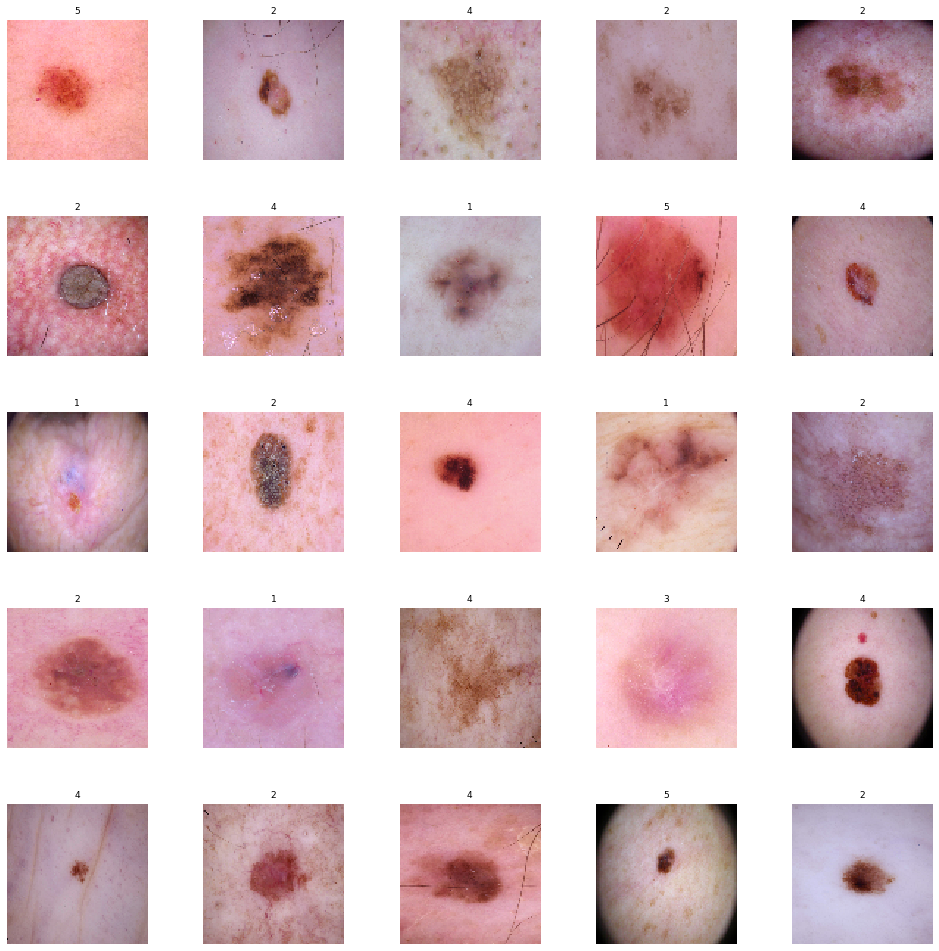

In [16]:
w_grid = 5
l_grid = 5
fig, axes = plt.subplots(w_grid, l_grid, figsize = (17, 17))
axes = axes.ravel()
for i in range(0, len(axes)):
    j = np.random.randint(0, len(x_train))
    axes[i].imshow(x_train[j].reshape(96, 96, 3))
    axes[i].set_title(y_train[j], fontsize = 9)
    axes[i].axis('off')
plt.subplots_adjust(hspace = 0.4)

In [17]:
base_model = tf.keras.applications.DenseNet201(include_top = False, input_shape = (96, 96, 3), weights = 'imagenet')

In [18]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

Total params: 18,321,984
Trainable params: 18,092,928
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [19]:
global_avarage_polling = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
fully_connected_layer = tf.keras.layers.Dense(units = 1024, activation = 'relu')(global_avarage_polling)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 512, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 512, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 256, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dense(units = 128, activation = 'relu')(fully_connected_layer)
fully_connected_layer = tf.keras.layers.Dropout(0.5)(fully_connected_layer)
prediction_layer = tf.keras.layers.Dense(units = 7, activation = 'softmax')(fully_connected_layer)

In [20]:
classifier = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [21]:
classifier.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
_______________________________________________________________________________________

Total params: 21,241,671
Trainable params: 21,012,615
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [22]:
classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
                  metrics = ['accuracy'])

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
checkpoint = ModelCheckpoint('model/skin_cancer_classifier3.h5', monitor = 'val_loss', save_best_only = True,
                             mode = 'min', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_loss', patience = 7, mode = 'min', verbose = 1, restore_best_weights = True,
                          min_delta = 0.001)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, mode = 'min',
                              min_delta = 0.0001)

callback = [earlystop, checkpoint, reduce_lr]

In [24]:
epochs_history = classifier.fit(x = x_train, y = y_train_resized, epochs = 50, verbose = 1, callbacks = callback, 
                                validation_data = (x_valid, y_valid_resized))

Epoch 1/50
637/637 [==============================] - ETA: 0s - loss: 1.7282 - accuracy: 0.3064
Epoch 00001: val_loss improved from inf to 1.33563, saving model to model\skin_cancer_classifier3.h5
637/637 [==============================] - 3225s 5s/step - loss: 1.7282 - accuracy: 0.3064 - val_loss: 1.3356 - val_accuracy: 0.5086
Epoch 2/50
637/637 [==============================] - ETA: 0s - loss: 1.2389 - accuracy: 0.5056
Epoch 00002: val_loss improved from 1.33563 to 1.25104, saving model to model\skin_cancer_classifier3.h5
637/637 [==============================] - 3411s 5s/step - loss: 1.2389 - accuracy: 0.5056 - val_loss: 1.2510 - val_accuracy: 0.6035
Epoch 3/50
637/637 [==============================] - ETA: 0s - loss: 1.0438 - accuracy: 0.6388
Epoch 00003: val_loss improved from 1.25104 to 1.08552, saving model to model\skin_cancer_classifier3.h5
637/637 [==============================] - 3214s 5s/step - loss: 1.0438 - accuracy: 0.6388 - val_loss: 1.0855 - val_accuracy: 0.6508
Ep

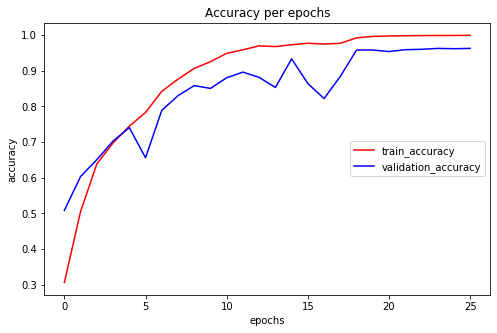

In [25]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history.history['val_accuracy'], c = 'blue', label = 'validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy per epochs')
plt.legend(loc = 'center right')
plt.show()

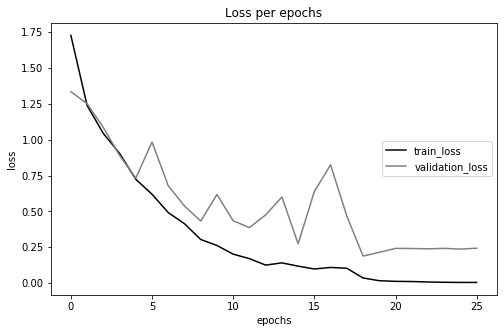

In [26]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss per epochs')
plt.legend(loc = 'center right')
plt.show()

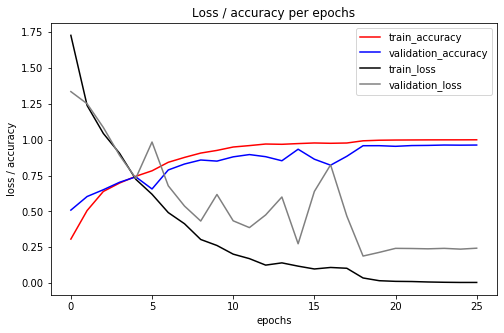

In [38]:
plt.figure(figsize = (8, 5))
plt.plot(epochs_history.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history.history['val_accuracy'], c = 'blue', label = 'validation_accuracy')
plt.plot(epochs_history.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss / accuracy')
plt.title('Loss / accuracy per epochs')
plt.legend(loc = 'upper right')
plt.show()

In [27]:
accuracy, loss = classifier.evaluate(x_test, y_test_resized)

13/13 [==============================] - 7s 553ms/step - loss: 0.1960 - accuracy: 0.9507


In [28]:
y_pred = classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

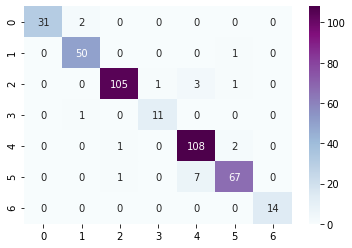

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test_resized, axis = 1), y_pred)
sns.heatmap(cm, annot=True, cmap="BuPu", fmt = 'd')

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
report = classification_report(np.argmax(y_test_resized, axis = 1), y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        33
           1       0.94      0.98      0.96        51
           2       0.98      0.95      0.97       110
           3       0.92      0.92      0.92        12
           4       0.92      0.97      0.94       111
           5       0.94      0.89      0.92        75
           6       1.00      1.00      1.00        14

    accuracy                           0.95       406
   macro avg       0.96      0.95      0.95       406
weighted avg       0.95      0.95      0.95       406



In [41]:
accuracy_score(np.argmax(y_test_resized, axis = 1), y_pred)

0.9507389162561576

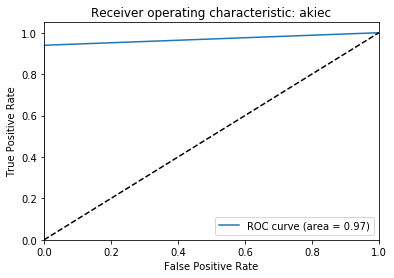

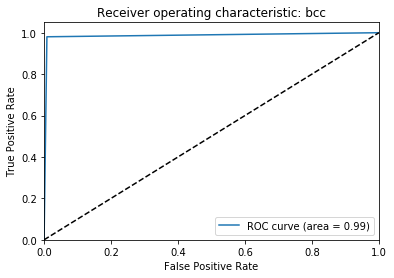

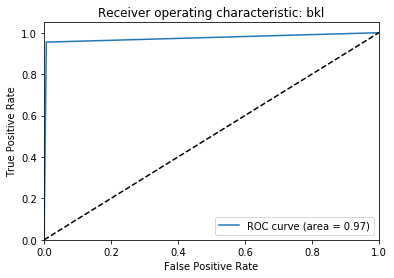

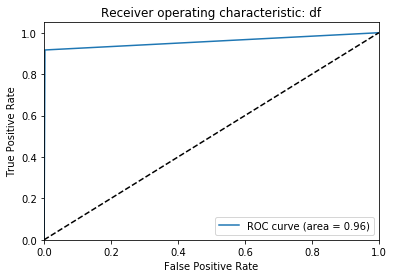

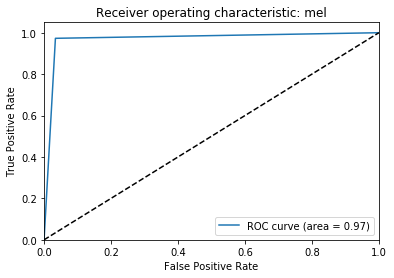

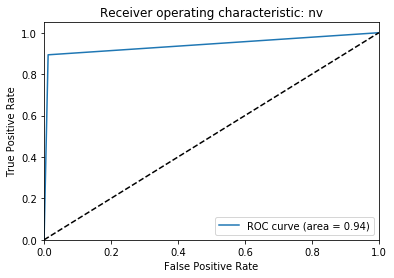

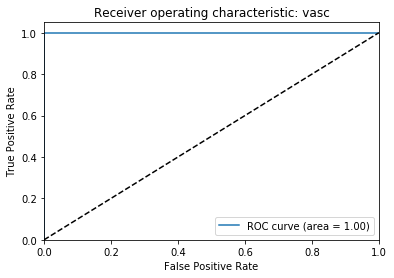

In [42]:
from sklearn.preprocessing import label_binarize
y_test1 = label_binarize((np.argmax(y_test_resized, axis = 1)), classes=[0,1,2,3,4,5,6])
y_pred1 = label_binarize(y_pred, classes=[0,1,2,3,4,5,6])
from sklearn.metrics import roc_curve, auc
disease = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
n_classes = 7
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ' + disease[i])
    plt.legend(loc="lower right")
plt.show()

In [43]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
from scipy import interp
from itertools import cycle
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\KIIT\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Receiver operating characteristic: DenseNet201')

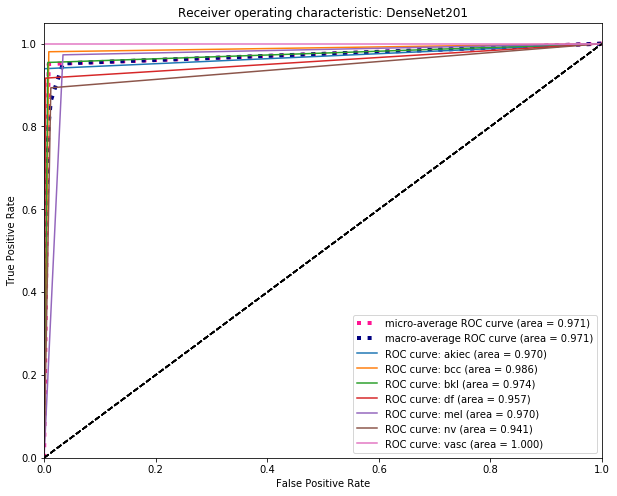

In [44]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label='ROC curve: '+ disease[i] + ' (area = %0.3f)' % roc_auc[i])
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower right")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic: DenseNet201')